In [1]:
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd
import joblib

In [4]:


# Define model files and names
model_files = {
    "XGBoost + SMOTE": { "model" : "../models/XGBoost_SMOTE.pkl", "test_data" : "../test_data/XGBoost_SMOTE_Test.pkl"},
    "XGBoost + ADASYN":{ "model" : "../models/XGBoost_ADASYN.pkl","test_data" : "../test_data/XGBoost_ADASYN_Test.pkl"},
    "LightGBM + SMOTE":{ "model" : "../models/LightGBM_SMOTE.pkl", "test_data" : "../test_data/LightGBM_SMOTE_Test.pkl"},
    "LightGBM + ADASYN":{ "model" : "../models/LightGBM_ADASYN.pkl", "test_data" : "../test_data/LightGBM_ADASYN_Test.pkl"},
    "Logistic + SMOTE":{ "model" : "../models/Logistic_SMOTE.pkl", "test_data" : "../test_data/Logistic_SMOTE_Test.pkl"},
    "Time_XGB + SMOTE":{"model" :  "../models/Time_based_XGBoost_SMOTE.pkl", "test_data" : "../test_data/Time_based_XGBoost_SMOTE_Test.pkl"},
    "Time_XGB + ADASYN":{ "model" :  "../models/Time_based_XGBoost_ADASYN.pkl", "test_data" : "../test_data/Time_based_XGBoost_ADASYN_Test.pkl"},
    "Time_LGBM + SMOTE":{ "model" :  "../models/Time_based_LightGBM_SMOTE.pkl", "test_data" : "../test_data/Time_based_LightGBM_SMOTE_Test.pkl"},
    "Time_LGBM + ADASYN":{ "model" : "../models/Time_based_LightGBM_ADASYN.pkl", "test_data" : "../test_data/Time_based_LightGBM_SMOTE_Test.pkl"}
}



Calculating the metric scores for each model and displaying

In [5]:
results = []
for name, paths in model_files.items():
    model = joblib.load(paths["model"])
    X_test, y_test = joblib.load(paths["test_data"])

    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Display results
df = pd.DataFrame(results)
display(df)

,Model,Precision,Recall,F1 Score
0,XGBoost + SMOTE,0.348549,0.994522,0.516190
1,XGBoost + ADASYN,0.270813,0.993914,0.425648
2,LightGBM + SMOTE,0.222615,0.995740,0.363879
3,LightGBM + ADASYN,0.174483,0.996348,0.296961
4,Logistic + SMOTE,0.022062,0.956981,0.043129
5,Time_XGB + SMOTE,0.825325,0.996977,0.903067
6,Time_XGB + ADASYN,0.747397,0.998186,0.854776
7,Time_LGBM + SMOTE,0.726552,0.997582,0.840764
8,Time_LGBM + ADASYN,0.619602,0.997582,0.764420


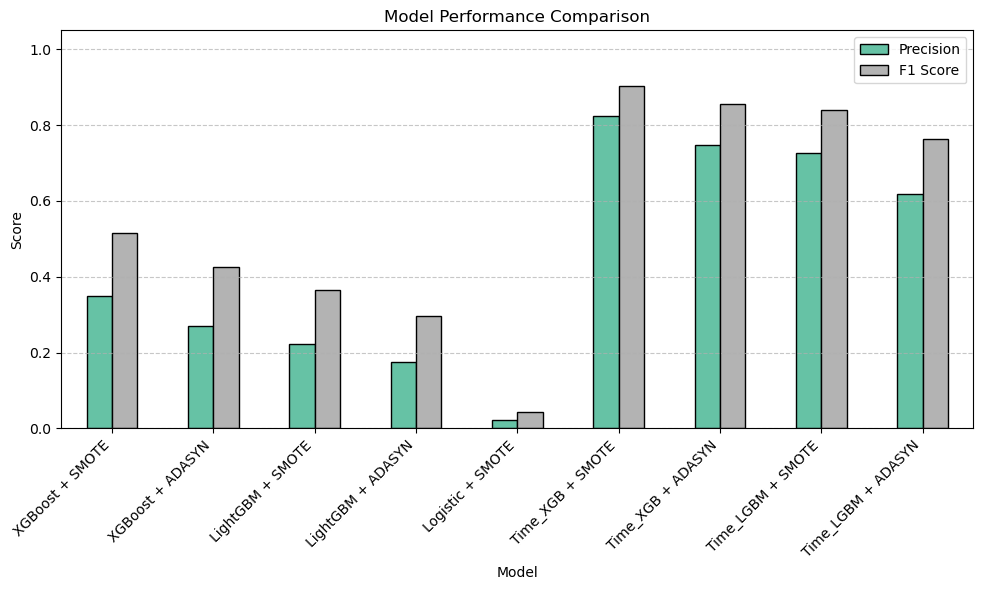

In [4]:
# Bar plot
df.set_index("Model")[["Precision", "F1 Score"]].plot(
    kind="bar", figsize=(10, 6), colormap="Set2", edgecolor='black'
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Metric based threshold tuning**

In [8]:

def find_best_threshold(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0, 1, 101)
    best_threshold = 0.5
    best_f1 = 0

    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


Finding metric score after threshold tuning along with cost involved and displaying

In [9]:
results = []

# Updated to use both model and corresponding test data
for name, paths in model_files.items():
    model = joblib.load(paths["model"])
    X_test, y_test = joblib.load(paths["test_data"])  # load test set for this model

    threshold, best_f1 = find_best_threshold(model, X_test, y_test)
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    tn_, fp_, fn_, tp_ = confusion_matrix(y_test, preds).ravel()
    cost_ = 10000 * fn_ + 100 * fp_

    results.append({
        "Model": name,
        "Threshold": round(threshold, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(best_f1, 4),
        "False Positives": fp_,
        "False Negatives": fn_,
        "Cost": cost_
    })

df = pd.DataFrame(results)
display(df)

,Model,Threshold,Precision,Recall,F1 Score,False Positives,False Negatives,Cost
0,XGBoost + SMOTE,0.99,0.8008,0.8929,0.8443,365,176,1796500
1,XGBoost + ADASYN,0.99,0.5903,0.9148,0.7176,1043,140,1504300
2,LightGBM + SMOTE,0.99,0.8688,0.7821,0.8232,194,358,3599400
3,LightGBM + ADASYN,0.94,0.4222,0.9836,0.5908,2212,27,491200
4,Logistic + SMOTE,0.99,0.3321,0.6209,0.4328,3077,934,9647700
5,Time_XGB + SMOTE,0.97,0.9292,0.9764,0.9522,123,39,402300
6,Time_XGB + ADASYN,0.96,0.8990,0.9843,0.9397,183,26,278300
7,Time_LGBM + SMOTE,0.96,0.9220,0.9867,0.9533,138,22,233800
8,Time_LGBM + ADASYN,0.91,0.8559,0.9873,0.9169,275,21,237500


Plotting

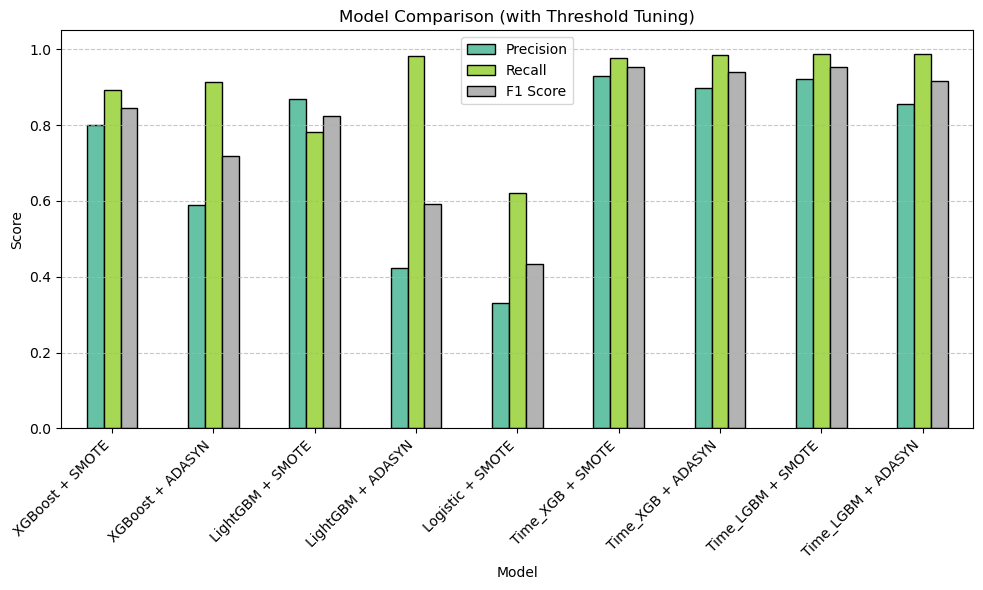

In [10]:
df.set_index("Model")[["Precision", "Recall", "F1 Score"]].plot(
    kind="bar", figsize=(10, 6), colormap="Set2", edgecolor='black'
)
plt.title("Model Comparison (with Threshold Tuning)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Observations** : Threshold tuning based on metrics suggests that best model is **XGBoost + SMOTE**, and second model, very close in performance is **LightGBM + SMOTE**

**Cost based threshold tuning**

In [11]:
# Custom cost function: FN = ₹10,000, FP = ₹100
def cost_sensitive_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn * 10000 + fp * 100
    return cost

In [12]:
# Thresholds to try
thresholds = np.linspace(0.01, 0.99, 100)

results = []

# Iterate through each model and its corresponding test data
for name, paths in model_files.items():
    model = joblib.load(paths["model"])
    X_test, y_test = joblib.load(paths["test_data"])  # model-specific test set

    # Get probabilities
    try:
        y_proba = model.predict_proba(X_test)
        if y_proba.ndim == 2 and y_proba.shape[1] == 2:
            y_proba = y_proba[:, 1]
    except:
        y_proba = model.decision_function(X_test)
        y_proba = 1 / (1 + np.exp(-y_proba))  # sigmoid

    # Search for best threshold
    best_threshold = 0.5
    min_cost = float('inf')
    best_preds = None

    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        cost = cost_sensitive_score(y_test, y_pred_thresh)

        if cost < min_cost:
            min_cost = cost
            best_threshold = thresh
            best_preds = y_pred_thresh.copy()

    # Compute metrics at best threshold
    precision = precision_score(y_test, best_preds)
    recall = recall_score(y_test, best_preds)
    f1 = f1_score(y_test, best_preds)

    print(f"\n=== {name} ===")
    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Minimum Cost: ₹{min_cost:,}")
    print("Classification Report:\n")
    print(classification_report(y_test, best_preds, digits=4))

    results.append({
        "Model": name,
        "Best Threshold": round(best_threshold, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "Cost": min_cost
    })

# Final comparison table
df_cost_eval = pd.DataFrame(results)
display(df_cost_eval)


=== XGBoost + SMOTE ===
Best Threshold: 0.7920
Minimum Cost: ₹319,800
Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9985    0.9992   1270881
           1     0.4620    0.9921    0.6304      1643

    accuracy                         0.9985   1272524
   macro avg     0.7310    0.9953    0.8148   1272524
weighted avg     0.9993    0.9985    0.9988   1272524


=== XGBoost + ADASYN ===
Best Threshold: 0.9009
Minimum Cost: ₹334,100
Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9985    0.9992   1270881
           1     0.4563    0.9915    0.6250      1643

    accuracy                         0.9985   1272524
   macro avg     0.7281    0.9950    0.8121   1272524
weighted avg     0.9993    0.9985    0.9987   1272524


=== LightGBM + SMOTE ===
Best Threshold: 0.9009
Minimum Cost: ₹355,700
Classification Report:

              precision    recall  f1-score   support

    

,Model,Best Threshold,Precision,Recall,F1 Score,Cost
0,XGBoost + SMOTE,0.7920,0.4620,0.9921,0.6304,319800
1,XGBoost + ADASYN,0.9009,0.4563,0.9915,0.6250,334100
2,LightGBM + SMOTE,0.9009,0.4303,0.9915,0.6001,355700
3,LightGBM + ADASYN,0.9009,0.4047,0.9951,0.5754,320500
4,Logistic + SMOTE,0.7920,0.0570,0.8584,0.1070,6987200
5,Time_XGB + SMOTE,0.4852,0.8221,0.9976,0.9014,75700
6,Time_XGB + ADASYN,0.6732,0.8101,0.9982,0.8944,68700
7,Time_LGBM + SMOTE,0.8514,0.8571,0.9976,0.9220,67500
8,Time_LGBM + ADASYN,0.8910,0.8418,0.9976,0.9131,71000


**Observations** : In terms of minimizing cost, **XGBoost + SMOTE** incurs minimum cost of Rs 3,19,800, and very close performance of **LightGBM + ADASYN** is observed that incurs minimum cost of Rs 3,20,500

% Cost reduction after costbased threshold tuning

In [13]:
difference = (df["Cost"] - df_cost_eval["Cost"])*100 / df["Cost"]


reduction_df = pd.DataFrame(df_cost_eval["Model"])
reduction_df["Cost after metric based threshold tuning"] = df["Cost"]
reduction_df["Cost after cost based thresholf tuning"] = df_cost_eval["Cost"]
reduction_df["% Cost reduced"] = difference
display(reduction_df)

,Model,Cost after metric based threshold tuning,Cost after cost based thresholf tuning,% Cost reduced
0,XGBoost + SMOTE,1796500,319800,82.198720
1,XGBoost + ADASYN,1504300,334100,77.790334
2,LightGBM + SMOTE,3599400,355700,90.117797
3,LightGBM + ADASYN,491200,320500,34.751629
4,Logistic + SMOTE,9647700,6987200,27.576521
5,Time_XGB + SMOTE,402300,75700,81.183197
6,Time_XGB + ADASYN,278300,68700,75.314409
7,Time_LGBM + SMOTE,233800,67500,71.129170
8,Time_LGBM + ADASYN,237500,71000,70.105263


SHAP analysis

In [14]:
import shap
import joblib

In [16]:
# Load test set
pipeline = joblib.load(r'D:\IEOR\3rd Sem\Fraud detection\Models\Time_based_LightGBM_SMOTE.pkl')
# Load trained model
X_test, y_test = joblib.load(r'D:\IEOR\3rd Sem\Fraud detection\Test\Time_based_LightGBM_SMOTE_Test.pkl')



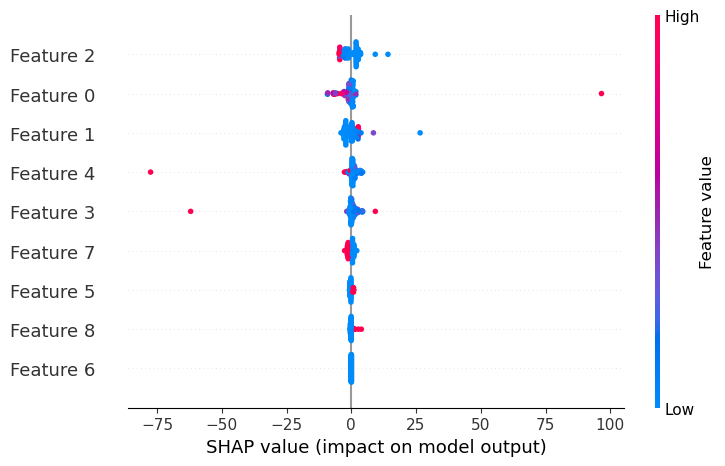

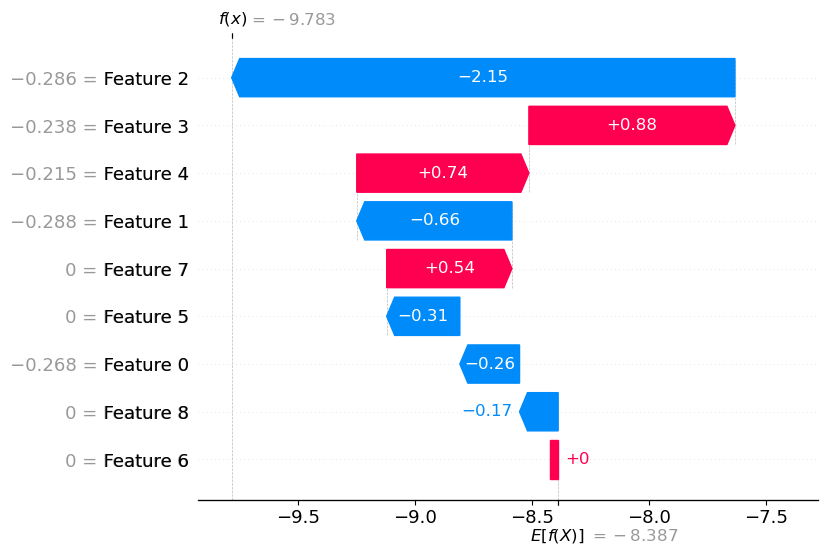

In [17]:
# Extract model and preprocessor
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['classifier']

# Transform X_test using the preprocessor
sample_X = X_test.sample(n=100, random_state=42)

X_test_transformed = preprocessor.transform(sample_X)

# Use TreeExplainer on the transformed data
explainer = shap.Explainer(model, X_test_transformed)
shap_values = explainer(X_test_transformed)

# Plot
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[0])


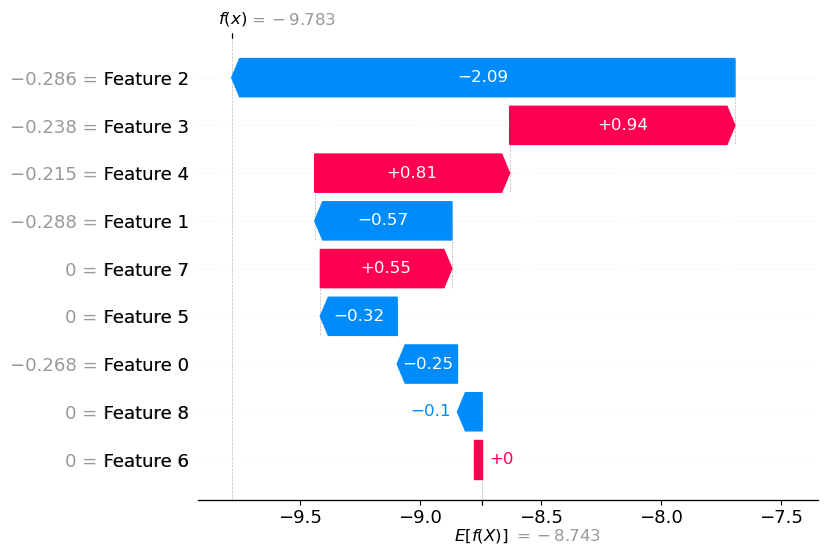

In [18]:
# Extract model and preprocessor from the pipeline
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['classifier']

# Sample 100 rows from X_test and corresponding labels
sample_X = X_test.sample(n=100, random_state=42)
sample_y = y_test.loc[sample_X.index]

# Transform sample data
sample_X_transformed = preprocessor.transform(sample_X)

# Make predictions
y_pred_sample = model.predict(sample_X_transformed)

# Identify misclassified fraud cases
wrong_preds = (y_pred_sample != sample_y.values)
fraud_misclassified = sample_X[(sample_y == 1) & wrong_preds]

# Fraud case: misclassified
if not fraud_misclassified.empty:
    fraud_transformed = preprocessor.transform(fraud_misclassified)
    explainer_fraud = shap.Explainer(model, fraud_transformed)
    fraud_shap_values = explainer_fraud(fraud_transformed)
    shap.plots.waterfall(fraud_shap_values[0], show=True)

# Non-fraud case: correctly classified
correct_nonfraud = sample_X[(sample_y == 0) & (y_pred_sample == 0)]
if not correct_nonfraud.empty:
    legit_transformed = preprocessor.transform(correct_nonfraud)
    explainer_legit = shap.Explainer(model, legit_transformed)
    legit_shap_values = explainer_legit(legit_transformed)
    shap.plots.waterfall(legit_shap_values[0], show=True)


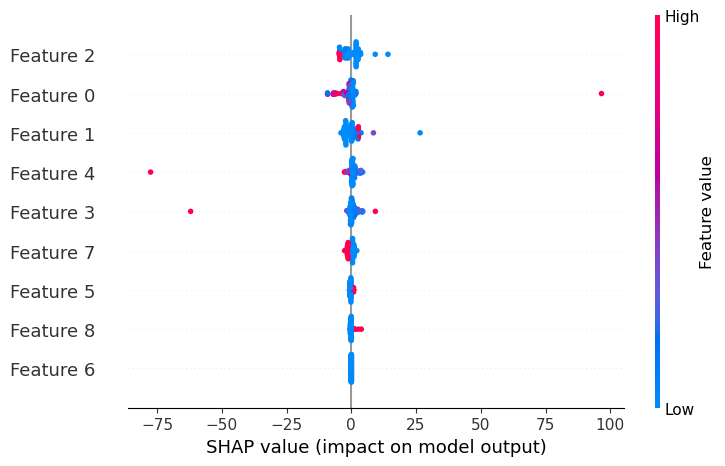

In [19]:
explainer = shap.Explainer(model, sample_X_transformed)
shap_values = explainer(sample_X_transformed)

# SHAP summary (beeswarm) plot
shap.plots.beeswarm(shap_values, show=True)